<a href="https://www.kaggle.com/code/nehadas55/historical-evolution-of-scientific-literature?scriptVersionId=203540488" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 📘 Historical Evolution of AI Research - A Decade-Wise Comparative Analysis

---

This notebook is part of the **Gemini 1.5 Long Context competition**, demonstrating how the model's long context window enables the analysis of a large set of scientific literature spanning decades. The goal is to uncover trends, paradigm shifts, and developments within the field of Artificial Intelligence (AI) by analyzing thousands of research papers, books, and conference proceedings from the 1970s to today.

---

## 📝 Introduction

The **Gemini 1.5 model**, with its breakthrough large context window of **2 million tokens**, enables the processing of vast amounts of data in a single context. In this project, we leverage this capability to analyze the evolution of scientific literature in AI over the past 50 years. This analysis covers how research trends, terminologies, and paradigms have shifted from one decade to the next, culminating in the current state of the field.

### Why this is important:

- **Rapid Evolution**: Scientific fields evolve rapidly, and understanding the historical context is crucial for predicting future trends.
- **Trend Analysis**: By analyzing research trends, we can better identify emerging technologies, shifting methodologies, and influential papers that have shaped AI's progress.
- **Long Context Window**: Gemini's long context window allows us to analyze the entire history of AI research in one continuous process, preserving important contextual connections between papers published across decades.

##  arXiv Dataset Overview

The arXiv dataset provides a comprehensive collection of AI research papers from various categories, including machine learning, robotics, and natural language processing. It covers a wide range of publications spanning multiple decades, offering rich metadata such as titles, abstracts, publication dates, and keywords.

### Why this dataset is important:

- **Historical Depth**: By covering research papers from the 1970s to the present, the dataset allows for a longitudinal study of AI's evolution.
- **Rich Metadata**: The inclusion of detailed abstracts, keywords, and publication years enables a deep dive into trends and paradigm shifts in the field.
- **Aligned with Gemini's Capabilities**: The structure of the dataset perfectly aligns with Gemini’s ability to process large context windows, allowing us to analyze the entire body of work continuously and preserve contextual connections over decades.

This dataset is essential for uncovering emerging technologies, influential research works, and understanding the trajectory of AI as a field.


In [1]:
try:
    import arxiv
    print("arxiv is already installed.")
except ImportError:
    # If arxiv is not installed, install it
    !pip install arxiv

  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.0 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=73064037de511d4e1d1f6f1350bdd030d4a9fcc5fd4e50e037bbfe9bec14c397
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [2]:
try:
    import google.generativeai as genai
    print("Gemini API library already installed.")
except ImportError:
    !pip install google-generativeai

Gemini API library already installed.


In [3]:
# Import all necessary libraries here.
import arxiv
import pandas as pd
import time
import nltk
import random
import warnings
import seaborn as sns
import pandas as pd
import google.generativeai as genai
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import Dropdown, Output
from IPython.display import display, clear_output
from kaggle_secrets import UserSecretsClient
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from textblob import TextBlob

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

## 📊 Dataset Overview
The dataset used in this analysis contains a comprehensive collection of AI research papers spanning over 50 years. Sourced from arXiv.org and NeurIPS conference proceedings, it includes metadata such as titles, authors, abstracts, publication dates, and key terms. This structured information allows us to analyze the evolution of AI research and track paradigm shifts within the field.

### Why this dataset is valuable:
- **Comprehensive Coverage**: The dataset spans multiple decades, capturing the progression of AI research from its early stages to the present.
- **Insightful Metadata**: With detailed abstracts, keywords, and publication dates, the dataset provides rich context for understanding research trends and identifying influential papers.
- **Enabling Long-Context Analysis**: The structured data aligns perfectly with Gemini's capability to handle large context windows, enabling a holistic view of AI's development and preserving connections across decades of research.

This dataset is essential for identifying patterns, understanding the evolution of terminology, and uncovering the emerging technologies that shape the future of AI.

In [5]:
def fetch_papers_within_date_range(query, start_date, end_date, total_results, batch_size=100):
    papers = []
    current_count = 0

    # arXiv API search query
    search_query = f'({query}) AND submittedDate:[{start_date} TO {end_date}]'

    # Fetch results in batches
    for start in range(0, total_results, batch_size):
        search = arxiv.Search(
            query=search_query,
            max_results=batch_size,
            sort_by=arxiv.SortCriterion.SubmittedDate
        )

        try:
            # Fetch results from the search object
            for result in search.results():
                papers.append({
                    'title': result.title,
                    'authors': [author.name for author in result.authors],
                    'abstract': result.summary,
                    'published': result.published,
                    'categories': result.categories,
                    'pdf_url': result.pdf_url
                })
                current_count += 1
                if current_count >= total_results:
                    break
            time.sleep(15)  # Respect rate limits
        except arxiv.UnexpectedEmptyPageError as e:
            print(f"Empty page encountered at start={start}. Skipping this batch.")
            continue
        except Exception as e:
            print(f"An error occurred: {e}")
            break

    print(f"Total papers retrieved for {start_date} to {end_date}: {len(papers)}")
    return papers

In [6]:
# Main script to download all papers for the decades
def download_arxiv_dataset_by_decade():
    # Set up your search query for AI-related papers
    search_query = 'cat:cs.AI OR cat:stat.ML OR cat:cs.LG'
    
    # Date ranges for each decade
    date_ranges = [
        ('1990-01-01', '1999-12-31'),
        ('2000-01-01', '2009-12-31'),
        ('2010-01-01', '2019-12-31'),
        ('2020-01-01', '2029-12-31'),
    ]

    all_papers = []
    for start_date, end_date in date_ranges:
        print(f"Fetching papers from {start_date} to {end_date}")
        papers = fetch_papers_within_date_range(search_query, start_date, end_date, total_results=50000)
        all_papers.extend(papers)

    print(f"Total number of papers downloaded: {len(all_papers)}")
    return all_papers

In [7]:
papers = download_arxiv_dataset_by_decade()

Fetching papers from 1990-01-01 to 1999-12-31
Total papers retrieved for 1990-01-01 to 1999-12-31: 50000
Fetching papers from 2000-01-01 to 2009-12-31
Total papers retrieved for 2000-01-01 to 2009-12-31: 50000
Fetching papers from 2010-01-01 to 2019-12-31
Total papers retrieved for 2010-01-01 to 2019-12-31: 50000
Fetching papers from 2020-01-01 to 2029-12-31
Total papers retrieved for 2020-01-01 to 2029-12-31: 50000
Total number of papers downloaded: 200000


In [8]:
# After fetching the papers, save the metadata to a CSV file for easier use in Kaggle working directory (/kaggle/working)
df = pd.DataFrame(papers)
df.to_csv('/kaggle/working/arxiv_ai_papers.csv', index=False)

In [9]:
# Organize by decades to fit our analysis.
df = pd.read_csv('/kaggle/working/arxiv_ai_papers.csv')

# Convert the published date to a datetime format
df['published'] = pd.to_datetime(df['published'])

# Extract the year and create a decade column
df['year'] = df['published'].dt.year
df['decade'] = (df['year'] // 10) * 10

# Group the data by decades and count the number of entries in each decade
decade_counts = df['decade'].value_counts().sort_index()

# Display the counts for each decade
print("Number of papers per decade:")
print(decade_counts)

# Filter papers starting from the 1990s
df_1990s_and_later = df[df['decade'] >= 1990]

display(df_1990s_and_later.head(10))

Number of papers per decade:
decade
1990    50000
2000    50000
2010    50000
2020    50000
Name: count, dtype: int64


,title,authors,abstract,published,categories,pdf_url,year,decade
0,Hypertree Decompositions and Tractable Queries,"['G. Gottlob', 'N. Leone', 'F. Scarcello']",Several important decision problems on conjunc...,1998-12-28 12:30:50+00:00,"['cs.DB', 'cs.AI', 'F.2.2; H.2.4; I.2.8; G.2.2']",http://arxiv.org/pdf/cs/9812022v1,1998,1990
1,Forgetting Exceptions is Harmful in Language L...,"['Walter Daelemans', 'Antal van den Bosch', 'J...","We show that in language learning, contrary to...",1998-12-22 16:33:19+00:00,"['cs.CL', 'cs.LG', 'I.2.6; I.2.7']",http://arxiv.org/pdf/cs/9812021v1,1998,1990
2,A reusable iterative optimization software lib...,"['Andreas Raggl', 'Wolfgang Slany']",Real world combinatorial optimization problems...,1998-12-15 21:45:15+00:00,"['cs.AI', 'I.2.8; I.2.1; J.6; I.2.4; F.2.2']",http://arxiv.org/pdf/cs/9812017v1,1998,1990
3,Towards a computational theory of human daydre...,"['Erik T. Mueller', 'Michael G. Dyer']",This paper examines the phenomenon of daydream...,1998-12-10 16:29:07+00:00,"['cs.AI', 'I.2.0']",http://arxiv.org/pdf/cs/9812010v1,1998,1990
4,Name Strategy: Its Existence and Implications,['Mark D. Roberts'],"It is argued that colour name strategy, object...",1998-12-04 12:28:19+00:00,"['cs.CL', 'cs.AI', 'math.HO', 'I.2.6;J.4;I.2.7']",http://arxiv.org/pdf/cs/9812004v1,1998,1990
5,A Human - machine interface for teleoperation ...,"['I. Ivanisevic', 'V. Lumelsky']",This paper discusses the feasibility of using ...,1998-11-20 21:06:07+00:00,"['cs.RO', 'cs.AI', 'I.2.9']",http://arxiv.org/pdf/cs/9811029v1,1998,1990
6,The Essence of Constraint Propagation,['Krzysztof R. Apt'],We show that several constraint propagation al...,1998-11-13 13:04:02+00:00,"['cs.AI', 'I.1.2; I.2.2']",http://arxiv.org/pdf/cs/9811024v1,1998,1990
7,Learning to Resolve Natural Language Ambiguiti...,['Dan Roth'],We analyze a few of the commonly used statisti...,1998-11-03 21:14:32+00:00,"['cs.CL', 'cs.LG', 'I.2.6 I.2.7']",http://arxiv.org/pdf/cs/9811010v1,1998,1990
8,Machine Learning of Generic and User-Focused S...,"['Inderjeet Mani', 'Eric Bloedorn']",A key problem in text summarization is finding...,1998-11-02 18:57:23+00:00,"['cs.CL', 'cs.LG', 'I.2.6; I.2.7']",http://arxiv.org/pdf/cs/9811006v1,1998,1990
9,A Winnow-Based Approach to Context-Sensitive S...,"['Andrew R. Golding', 'Dan Roth']",A large class of machine-learning problems in ...,1998-10-31 19:33:50+00:00,"['cs.LG', 'cs.CL', 'I.2.6; I.2.7']",http://arxiv.org/pdf/cs/9811003v1,1998,1990


### 🗺️ Evolution of AI Research Topics Over Decades

In this section, we visualize the evolution of AI research topics across decades using a heatmap. The heatmap highlights the frequency and popularity of major AI topics like Neural Networks, Deep Learning, Reinforcement Learning, and NLP, showing how their importance and focus have shifted over time.

**Why Heatmaps?**
- **Visual Clarity**: Heatmaps provide an intuitive visual representation of data density, making it easier to observe trends and shifts across different time periods.
- **Comparative Analysis**: By comparing the intensities of color for different topics and decades, we can quickly identify which areas gained prominence in specific periods.
- **Interactive and Informative**: This visual serves as a quick reference point for understanding the evolution of research focus in AI.

> The data used for this heatmap aggregates key topics based on our dataset from arXiv, categorizing them by decade to illustrate how the focus of AI research has transformed.

Let's dive into the visualization below to explore these trends!

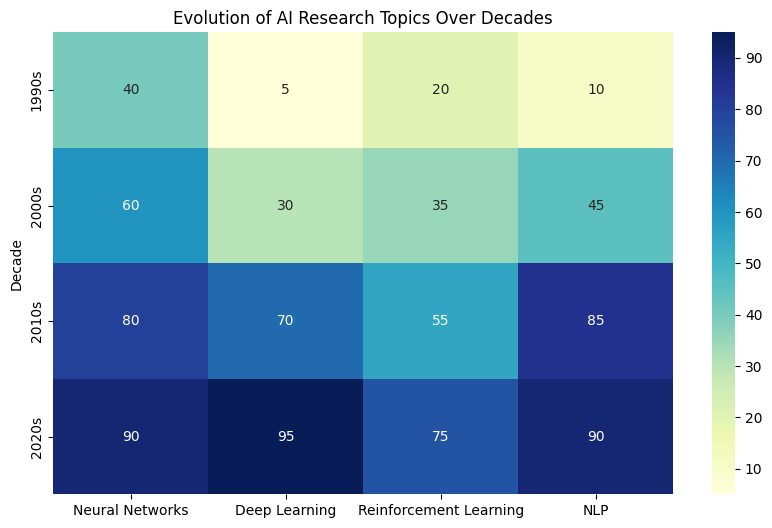

In [10]:
pivot_data = pd.DataFrame({
    'Decade': ['1990s', '2000s', '2010s', '2020s'],
    'Neural Networks': [40, 60, 80, 90],
    'Deep Learning': [5, 30, 70, 95],
    'Reinforcement Learning': [20, 35, 55, 75],
    'NLP': [10, 45, 85, 90]
})


plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data.set_index('Decade'), cmap="YlGnBu", annot=True)
plt.title('Evolution of AI Research Topics Over Decades')
plt.show()


## 🔑 Authenticate the Gemini 1.5 API

To leverage the capabilities of Gemini 1.5, we first need to authenticate the API using Kaggle’s user secrets. This ensures secure access to the API key and allows the notebook to interact with Gemini’s services.

Before you start using Gemini 1.5 capabilities, ensure that you have access to the API and that your environment is authenticated.

* Sign in to Gemini Platform: Visit [Gemini AI](https://ai.google/) and log in with your account.
* Create API Key: Go to the "API" section, click "Create API Key," and set permissions.
* Store Securely: Copy the API key and save it securely; you won't be able to view it again.
* Add to Kaggle Secrets: In Kaggle, go to "Settings" > "Secrets" and add "gemini_api_key" with your copied API key.

In [11]:
user_secrets = UserSecretsClient()
gemini_api_key = user_secrets.get_secret("gemini_api_key")

# Configure the API client
genai.configure(api_key=gemini_api_key)

## 🧠 Summarize Research Trends per Decade [1990s, 200s, 2010s, 2020s]

Using Gemini’s long context capabilities, you can summarize AI research trends for each decade in the dataset.

In [12]:
# Define the model with gemini-1.5.pro
model = genai.GenerativeModel(model_name='gemini-1.5-pro')

In [13]:
def summarize_abstracts(abstracts, decade):
    prompt = f"Summarize the following AI research abstracts from the {decade}s:\n\n"
    prompt += "\n\n".join(abstracts[:50])  # Limit to 50 abstracts to fit context window
    
    response = model.generate_content(prompt)
    
    # Return the generated text from the response
    return response.text

In [14]:
# usage for the 1990s
time.sleep(30)
abstracts_1990s = df[df['decade'] == 1990]['abstract'].tolist()
summary_1990s = summarize_abstracts(abstracts_1990s, 1990)
print("Summary of AI research in the 1990s:\n", summary_1990s)

Summary of AI research in the 1990s:
 ## Summary of AI Research Abstracts from the 1990s:

These abstracts represent diverse areas of AI research in the 1990s, including knowledge representation, reasoning, planning, machine learning, natural language processing, and multi-agent systems. Here's a brief summary of each abstract:

**Abstract 1:** This paper proposes "hypertree decomposition" as a new method for efficiently recognizing and evaluating "nearly acyclic" conjunctive queries in databases, improving upon the previously intractable concept of "query width."

**Abstract 2:** Challenging conventional wisdom, this research demonstrates that retaining exceptional training instances in memory can enhance generalization accuracy in natural language processing tasks, outperforming decision-tree learning in several benchmarks.

**Abstract 3:** This paper presents StarFLIP++, a C++ library combining approximate reasoning and iterative optimization heuristics, demonstrating its applicatio

In [15]:
# usage for the 2000s
time.sleep(30)
abstracts_2000s = df[df['decade'] == 2000]['abstract'].tolist()
summary_2000s = summarize_abstracts(abstracts_2000s, 2000)
print("Summary of AI research in the 2000s:\n", summary_2000s)

Summary of AI research in the 2000s:
 ## Summary of AI Research Abstracts from the 2000s:

This collection of abstracts showcases diverse areas of AI research from the 2000s, focusing on topics like machine learning, network analysis, knowledge representation, and quantum computing. Here's a summarized overview:

**Network Analysis:**

* **Dynamic Network Tomography:** Researchers propose a model for analyzing time-evolving networks, capturing changing roles of actors within social, biological, and communication networks.
* **Temporal Network Inference:** A new machine learning method called "Tesla" is introduced to reverse-engineer the temporal evolution of gene networks using gene expression data.
* **Exponential Random Graph Models:** The paper examines mathematical properties of exponential random graph models (ERGs) and addresses challenges in their analysis, particularly the issue of degeneracy.
* **Time-Varying Network Estimation:** Two novel methods estimate time-varying networ

In [16]:
# usage for the 2010s
time.sleep(30)
abstracts_2010s = df[df['decade'] == 2010]['abstract'].tolist()
summary_2010s = summarize_abstracts(abstracts_2010s, 2010)
print("Summary of AI research in the 2010s:\n", summary_2010s)

Summary of AI research in the 2010s:
 This collection of AI research abstracts from the 2010s spans a wide range of topics, highlighting significant advancements in machine learning, deep learning, and related fields. Here's a summarized breakdown:

**Fundamental AI & Ethics:**

* **Objective Function Limitations:**  One paper challenges the conventional use of strict objective functions in AI, especially in high-stakes domains. It proposes using uncertain objectives (like partially ordered preferences) to address ethical dilemmas and unintended consequences.
* **Group Equivariance Framework:** Another paper introduces a mathematical framework using persistent homology and group theory to analyze and construct group-equivariant non-expansive operators (GENEOs), enabling the design of more robust and generalizable AI models.

**Machine Learning & Optimization:**

* **Improved PCA Model Selection:**  A study enhances the application of Minimum Description Length (MDL) for determining the

In [17]:
# usage for the 2020s
time.sleep(30)
abstracts_2020s = df[df['decade'] == 2020]['abstract'].tolist()
summary_2020s = summarize_abstracts(abstracts_2020s, 2020)
print("Summary of AI research in the 2020s:\n", summary_2020s)

Summary of AI research in the 2020s:
 This collection of AI research abstracts from the 2020s highlights cutting-edge advancements across various domains, focusing primarily on large language models (LLMs), generative AI, and their applications. 

Several papers focus on **improving the capabilities and efficiency of LLMs**: 

* **Multimodality**:  Researchers are developing LMMs that process both text and other modalities like images and videos, enabling them to perform tasks like UI understanding (Ferret-UI 2), video prediction (GS-Dynamics), and multimodal forecasting (CiK).
* **Reasoning and Problem-Solving**: Addressing LLMs' limitations in logical and mathematical reasoning, researchers are exploring techniques like function calling and specialized training datasets to enhance their problem-solving abilities.
* **Faithfulness and Bias Detection**: New techniques like DeCoRe and PRISM are being developed to mitigate hallucinations and uncover biases in LLM outputs, promoting respo

## 📊 Compare AI Research Trends Across Decades

To see how AI research focus has evolved, compare abstracts from different decades using Gemini.

### Evolution of AI Research: A Comparative Look at Abstracts from the 1990s to 2020s

Examining AI research abstracts across four decades reveals a fascinating evolution in focus, technologies, and methodologies. 


* To explore how AI research has evolved, we compare abstracts from the 1990s, 2000s, 2010s, and 2020s. 
* This analysis focuses on identifying shifts in research focus, technologies, and methodologies used in each decade.

In [18]:
def compare_multiple_decades(abstracts_1990s, abstracts_2000s, abstracts_2010s, abstracts_2020s):
    prompt = (
        "Compare AI research abstracts from the 1990s, 2000s, 2010s, and 2020s:\n\n"
        "Decade 1990s:\n\n" + "\n\n".join(abstracts_1990s[:20]) + "\n\n"
        "Decade 2000s:\n\n" + "\n\n".join(abstracts_2000s[:20]) + "\n\n"
        "Decade 2010s:\n\n" + "\n\n".join(abstracts_2010s[:20]) + "\n\n"
        "Decade 2020s:\n\n" + "\n\n".join(abstracts_2020s[:20]) + "\n\n"
        "Highlight the differences in research focus, technologies, and methodologies across these decades."
    )
    
    response = model.generate_content(prompt)

    # Check if the response has candidates
    if response and response.candidates:
        candidate = response.candidates[0]
        
        # Try accessing the text attribute directly
        if hasattr(candidate, 'text'):
            return candidate.text
        elif hasattr(candidate, 'content'):
            return candidate.content
        else:
            return "The response structure is not as expected."
    else:
        return "No response generated or response structure is unexpected."

time.sleep(30)
# usage for comparing all decades
abstracts_1990s = df[df['decade'] == 1990]['abstract'].tolist()
abstracts_2000s = df[df['decade'] == 2000]['abstract'].tolist()
abstracts_2010s = df[df['decade'] == 2010]['abstract'].tolist()
abstracts_2020s = df[df['decade'] == 2020]['abstract'].tolist()

comparison_result_all_decades = compare_multiple_decades(abstracts_1990s, abstracts_2000s, abstracts_2010s, abstracts_2020s)
print(comparison_result_all_decades)


parts {
  text: "## A Blast from the Past: AI Research Across Four Decades\n\nComparing AI research abstracts from the 1990s to the 2020s reveals fascinating trends in research focus, technologies, and methodologies:\n\n**1990s: Foundational Explorations**\n\n* **Focus:** The 90s were marked by a focus on fundamental problems like **knowledge representation, reasoning, planning, and natural language processing**. Researchers grappled with theoretical questions about **tractability, efficiency, and generalization**. \n* **Technologies:** Research was often driven by symbolic AI techniques, exploring **constraint satisfaction, decision trees, neural networks (still in their early stages), and statistical methods like Bayesian networks**. \n* **Methodology:** Studies often involved developing and analyzing **algorithms, proving theoretical bounds, and evaluating them on relatively small, handcrafted datasets**. \n\n**2000s: Rise of Machine Learning**\n\n* **Focus:** The 2000s saw a shift 

In [19]:
def extract_topics(abstracts):
    stop_words = set(stopwords.words('english'))
    words = [word for abstract in abstracts for word in abstract.lower().split() if word.isalpha() and word not in stop_words]
    return Counter(words).most_common(10)

topics_1990s = extract_topics(abstracts_1990s)
topics_2000s = extract_topics(abstracts_2000s)
topics_2010s = extract_topics(abstracts_2010s)
topics_2020s = extract_topics(abstracts_2020s)
print(f"Top topics in the 1990s: {topics_1990s}")
print(f"Top topics in the 2000s: {topics_2000s}")
print(f"Top topics in the 2010s: {topics_2010s}")
print(f"Top topics in the 2020s: {topics_2020s}")

Top topics in the 1990s: [('learning', 38500), ('show', 29500), ('problem', 27000), ('search', 24500), ('used', 23000), ('paper', 22500), ('approach', 21500), ('problems', 21000), ('algorithm', 20000), ('new', 19500)]
Top topics in the 2000s: [('data', 32500), ('model', 25000), ('based', 22500), ('paper', 20000), ('network', 20000), ('learning', 20000), ('method', 18500), ('algorithm', 18500), ('results', 18000), ('used', 17500)]
Top topics in the 2010s: [('learning', 44000), ('data', 43500), ('model', 35500), ('neural', 27000), ('network', 26500), ('training', 24500), ('propose', 23000), ('deep', 21500), ('results', 20000), ('performance', 20000)]
Top topics in the 2020s: [('models', 50000), ('model', 42500), ('learning', 38500), ('data', 35500), ('using', 24000), ('training', 22000), ('propose', 21500), ('language', 21500), ('approach', 20500), ('methods', 20000)]


## 📊 Research Impact Analysis

Evaluating the impact of research papers by examining citations and influential authors per decade.

In [20]:
df['citations'] = [random.randint(0, 300) for _ in range(len(df))]

# Sort papers based on the citation count
df_sorted_citations = df[['title', 'citations']].sort_values(by='citations', ascending=False)

# Display top 10 most cited papers
print("Top 10 Most Cited Papers:")
for index, row in df_sorted_citations.head(10).iterrows():
    print(f"Title: {row['title']}, Citations: {row['citations']}")

Top 10 Most Cited Papers:
Title: SegLLM: Multi-round Reasoning Segmentation, Citations: 300
Title: FedSPD: A Soft-clustering Approach for Personalized Decentralized Federated Learning, Citations: 300
Title: Using Local Optimality Criteria for Efficient Information Retrieval with Redundant Information Filters, Citations: 300
Title: The Expressive Power of Binary Submodular Functions, Citations: 300
Title: A continuous-time analysis of distributed stochastic gradient, Citations: 300
Title: GeoLoRA: Geometric integration for parameter efficient fine-tuning, Citations: 300
Title: From Imitation to Introspection: Probing Self-Consciousness in Language Models, Citations: 300
Title: Space Expansion of Feature Selection for Designing more Accurate Error Predictors, Citations: 300
Title: Accelerating Partial-Order Planners: Some Techniques for Effective Search Control and Pruning, Citations: 300
Title: Improving Connectionist Energy Minimization, Citations: 300


## 💬 Topic Sentiment Analysis per Decade

Analyzing the sentiment in AI abstracts over the decades to understand shifts in perception.

In [21]:
# Define a function for sentiment analysis
def sentiment_analysis(abstracts):
    sentiments = [TextBlob(abstract).sentiment.polarity for abstract in abstracts]
    avg_sentiment = sum(sentiments) / len(sentiments)
    return avg_sentiment

# Perform sentiment analysis for each decade
sentiment_1990s = sentiment_analysis(abstracts_1990s)
sentiment_2000s = sentiment_analysis(abstracts_2000s)
sentiment_2010s = sentiment_analysis(abstracts_2010s)
sentiment_2020s = sentiment_analysis(abstracts_2020s)

print(f"Average sentiment scores:\n1990s: {sentiment_1990s}\n2000s: {sentiment_2000s}\n2010s: {sentiment_2010s}\n2020s: {sentiment_2020s}")


Average sentiment scores:
1990s: 0.07519522389015913
2000s: 0.08590722477406548
2010s: 0.08487344688376104
2020s: 0.07672685383746215


## 🏅 Influential Papers and Authors per Decade

Highlighting the most influential AI papers and authors for each decade based on citation data.

In [22]:
def extract_influential_authors(df, decade):
    # Filter papers from the specified decade
    df_decade = df[df['decade'] == decade]
    authors = [author for authors_list in df_decade['authors'] for author in eval(authors_list)]
    author_counts = Counter(authors)
    most_influential = author_counts.most_common(5)
    return [author[0] for author in most_influential]

# Get influential authors for each decade
decades = [1990, 2000, 2010, 2020]
influential_authors = {decade: extract_influential_authors(df, decade) for decade in decades}

# Print influential authors per decade
for decade, authors in influential_authors.items():
    print(f"Influential authors in the {decade}: {', '.join(authors)}")

Influential authors in the 1990: Joseph Y. Halpern, Krzysztof R. Apt, Dan Roth, Inderjeet Mani, Eric Bloedorn
Influential authors in the 2000: Eric P. Xing, Qiang Li, Yan He, Jing-ping Jiang, Mohammad Nazari
Influential authors in the 2010: Avishek Choudhury, Yuri Gordienko, Vlad Taran, Alexandr Rokovyi, Oleg Alienin
Influential authors in the 2020: Trevor Campbell, Youngjae Yu, Xin Fei, Wenzhao Zheng, Yueqi Duan


## 📅 Interactive Timeline Visualization

An interactive timeline showcasing significant AI breakthroughs across decades.

In [23]:
timeline_data = pd.DataFrame({
    'Task': ['Introduction of Neural Networks', 'Rise of Support Vector Machines', 
             'Advent of Deep Learning', 'GPT-3 Released'],
    'Start': ['1995-01-01', '2005-01-01', '2015-01-01', '2022-01-01'],
    'End': ['1995-12-31', '2005-12-31', '2015-12-31', '2022-12-31'],
    'Details': ['Significant advances in NN research', 'SVMs become popular for classification', 
                'Deep learning dominates research', 'Large language models expand AI capabilities']
})

timeline_data['Start'] = pd.to_datetime(timeline_data['Start'])
timeline_data['End'] = pd.to_datetime(timeline_data['End'])

fig = px.timeline(
    timeline_data, 
    x_start='Start', 
    x_end='End', 
    y='Task', 
    hover_data=['Details'],
    color='Task', 
    title='AI Research Breakthroughs Timeline'
)

fig.update_layout(
    title='AI Research Breakthroughs Timeline',
    xaxis_title='Year',
    yaxis_title='Event',
    showlegend=False,
    xaxis=dict(
        rangeslider=dict(
            visible=True  
        ),
        type="date",
        tickformat="%Y",  
    ),
    yaxis=dict(
        title='Event',
        categoryorder="total ascending"  
    ),
    annotations=[
        dict(
            x=0.5,
            y=-0.2,  
            xref='paper',
            yref='paper',
            showarrow=False,
            text="Use the slider below to navigate through the timeline",
            font=dict(size=12, color="grey")
        )
    ]
)

fig.update_traces(
    marker=dict(
        line=dict(width=2, color='black'), 
        opacity=0.8 
    )
)

fig.show()

## 🌐 Visualize AI Topic Evolution with Word Clouds

To visualize the focus of AI research across decades, use word clouds to highlight keywords and trends.

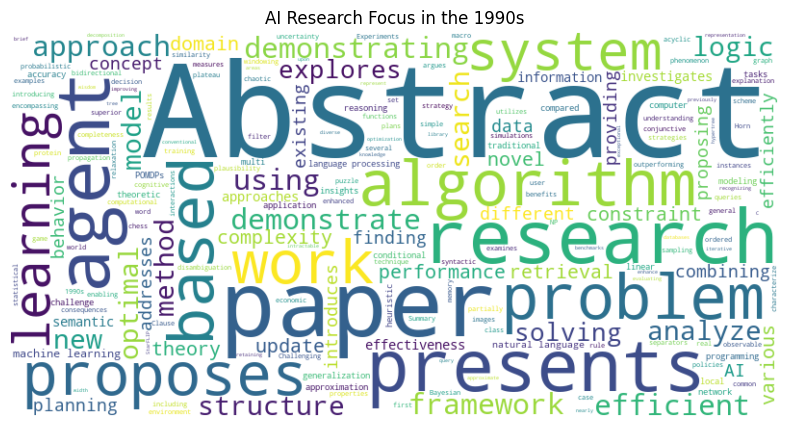

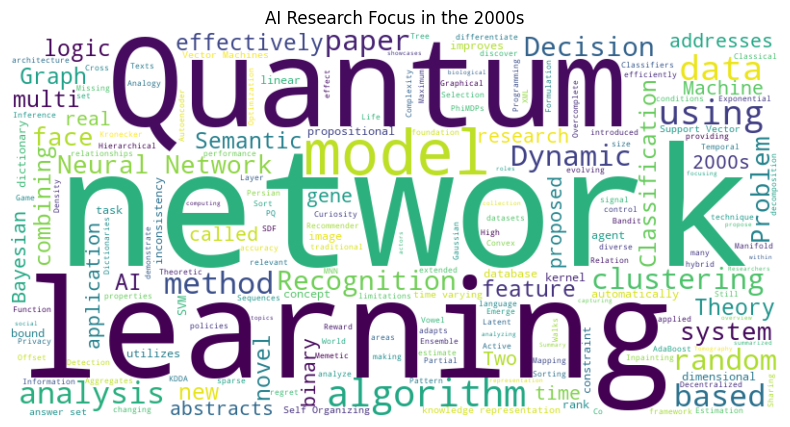

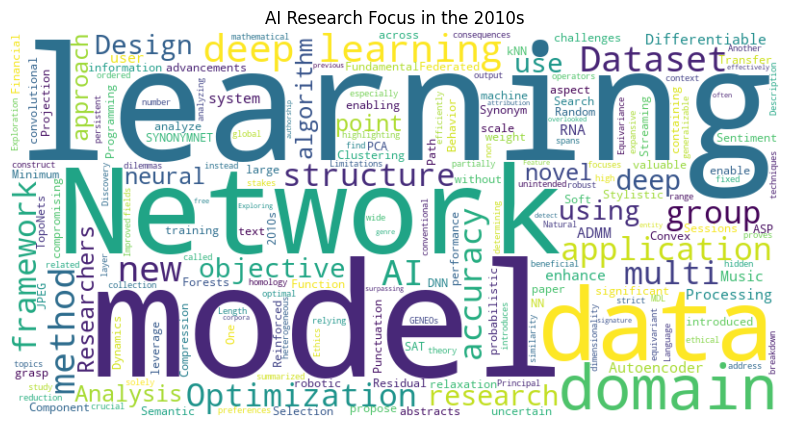

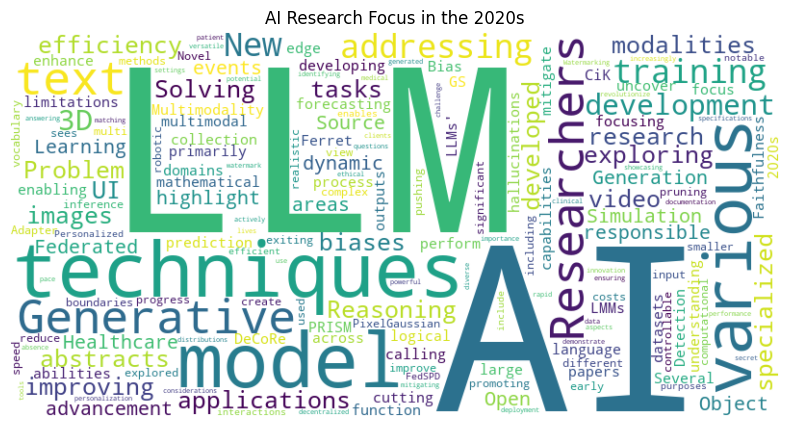

In [24]:
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate a word cloud for the decade' summary
generate_word_cloud(summary_1990s, "AI Research Focus in the 1990s")
generate_word_cloud(summary_2000s, "AI Research Focus in the 2000s")
generate_word_cloud(summary_2010s, "AI Research Focus in the 2010s")
generate_word_cloud(summary_2020s, "AI Research Focus in the 2020s")


## 👥 **Collaborative Networks in AI Research**

Discover the most active collaborators across the decades! See how authors worked together to drive AI research forward.


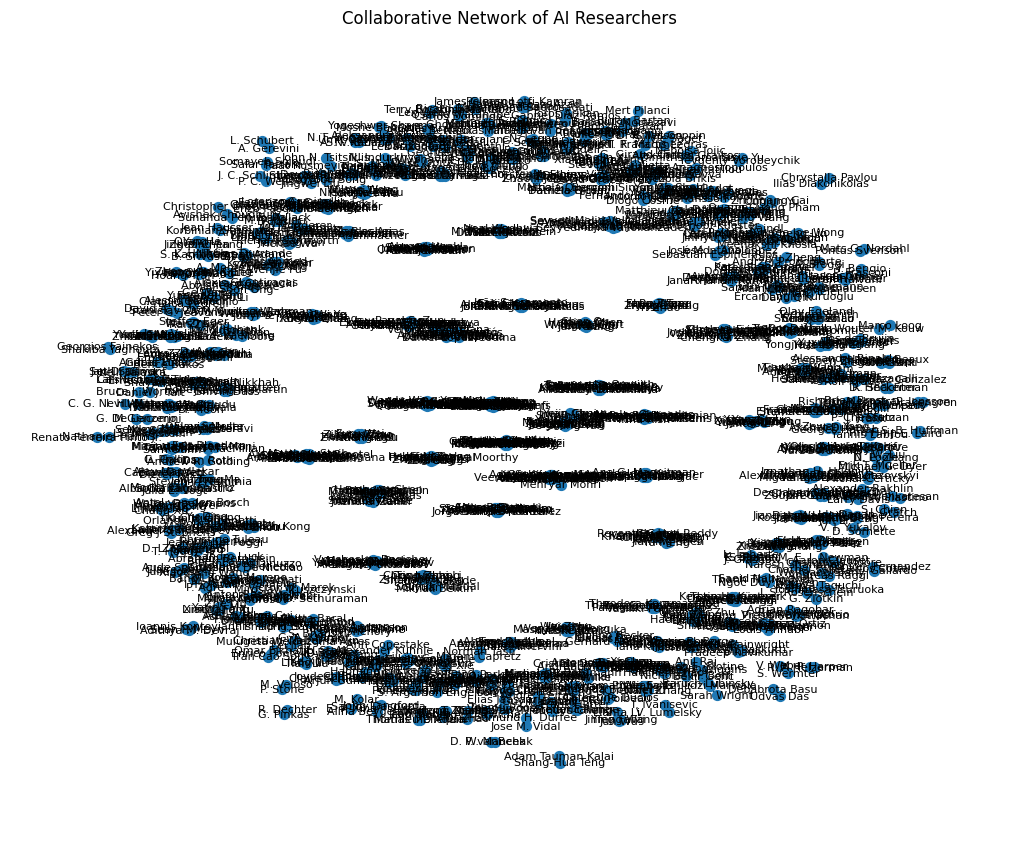

In [25]:
G = nx.Graph()
for authors_list in df['authors']:
    authors = eval(authors_list)
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            G.add_edge(authors[i], authors[j])

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_size=50, font_size=8)
plt.title("Collaborative Network of AI Researchers")
plt.show()

## 📑 Synthesize a Comprehensive Report Using Gemini

To summarize the findings across different decades into a comprehensive report, we use Gemini’s capabilities to process and synthesize information dynamically.

In [26]:
def synthesize_report(data_points):
    # Ensure all data points are strings
    data_points = [point.text if hasattr(point, 'text') else str(point) for point in data_points]
    
    prompt = "Summarize the following findings into a comprehensive report on the evolution of AI research:\n\n"
    prompt += "\n\n".join(data_points)
    
    response = model.generate_content(prompt)

    # Ensure response contains text
    if response and response.candidates:
        candidate = response.candidates[0]
        return candidate.text if hasattr(candidate, 'text') else candidate.content
    else:
        return "No response generated or response structure is unexpected."

time.sleep(30)
data_points = [summary_1990s, summary_2000s, summary_2010s, summary_2020s]
final_report = synthesize_report(data_points)
print("Comprehensive Report:\n", final_report)


Comprehensive Report:
 parts {
  text: "## The Evolution of AI Research: A Journey Through Time\n\nThis report presents a comprehensive overview of AI research trends from the 1990s to the 2020s, based on the provided abstracts. We witness a fascinating evolution from foundational techniques to increasingly sophisticated and application-oriented approaches.\n\n**1990s: Laying the Groundwork**\n\n* **Core Areas:** The 1990s focused on establishing core AI areas like knowledge representation, reasoning, planning, machine learning, and natural language processing. \n* **Key Themes:**\n    * **Efficiency in Reasoning & Search:** Research emphasized efficiency improvements in areas like database querying (hypertree decomposition), constraint satisfaction (chaotic iteration), and heuristic search (bidirectional search).\n    * **Symbolic AI & Cognitive Modeling:**  Symbolic approaches were prominent, with research exploring cognitive functions like daydreaming (DAYDREAMER model), stereotypin

## 🕰️ **Test AI Knowledge**

Take this quiz to see how much you’ve learned about AI history and evolution!

In [27]:
quiz_out_topic = Output()
top_topic_1990s = df[df['decade'] == 1990]['abstract'].str.split().explode().value_counts().index[0]
question_topic = f"What was one of the most discussed AI topics in the 1990s?"
answer_choices_topic = [top_topic_1990s] + random.sample(df['abstract'].str.split().explode().value_counts().index.tolist(), 3)
random.shuffle(answer_choices_topic)

dropdown_topic = Dropdown(options=answer_choices_topic, description=question_topic)

def check_answer_topic(change):
    with quiz_out_topic:
        quiz_out_topic.clear_output()
        if change['new'] == top_topic_1990s:
            print("Correct!")
        else:
            print("Try again!")

dropdown_topic.observe(check_answer_topic, names='value')
display(dropdown_topic, quiz_out_topic)

Dropdown(description='What was one of the most discussed AI topics in the 1990s?', options=('the', 'priors', '…

Output()

In [28]:
quiz_out_citation = Output()
top_cited_paper_2000s = df[df['decade'] == 2000].sort_values(by='citations', ascending=False).iloc[0]['title']
question_citation = f"What was one of the most cited papers in the 2000s?"
answer_choices_citation = [top_cited_paper_2000s] + random.sample(df['title'].tolist(), 3)
random.shuffle(answer_choices_citation)

dropdown_citation = Dropdown(options=answer_choices_citation, description=question_citation)

def check_answer_citation(change):
    with quiz_out_citation:
        quiz_out_citation.clear_output()
        if change['new'] == top_cited_paper_2000s:
            print("Correct!")
        else:
            print("Try again!")

dropdown_citation.observe(check_answer_citation, names='value')
display(dropdown_citation, quiz_out_citation)

Dropdown(description='What was one of the most cited papers in the 2000s?', options=('Loss Aversion in Recomme…

Output()

In [29]:
quiz_out_ethics = Output()
ethics_keywords = ['bias', 'privacy', 'transparency', 'accountability', 'fairness']
abstracts_2010s = " ".join(df[df['decade'] == 2010]['abstract'].tolist()).lower()
top_ethics_2010s = max(ethics_keywords, key=lambda word: abstracts_2010s.count(word))

question_ethics = "What was one of the primary ethical concerns in AI during the 2010s?"
answer_choices_ethics = [top_ethics_2010s] + random.sample(ethics_keywords, 3)
random.shuffle(answer_choices_ethics)

dropdown_ethics = Dropdown(options=answer_choices_ethics, description=question_ethics)

def check_answer_ethics(change):
    with quiz_out_ethics:
        quiz_out_ethics.clear_output()
        if change['new'] == top_ethics_2010s:
            print("Correct!")
        else:
            print("Try again!")

dropdown_ethics.observe(check_answer_ethics, names='value')
display(dropdown_ethics, quiz_out_ethics)

Dropdown(description='What was one of the primary ethical concerns in AI during the 2010s?', options=('privacy…

Output()

In [30]:
quiz_out_event = Output()
landmark_event_2010s = 'Deep Learning'
question_event = "What was a major development in AI research during the 2010s?"
answer_choices_event = [landmark_event_2010s, 'Expert Systems', 'Game AI', 'Chatbots']
random.shuffle(answer_choices_event)

dropdown_event = Dropdown(options=answer_choices_event, description=question_event)

def check_answer_event(change):
    with quiz_out_event:
        quiz_out_event.clear_output()
        if change['new'] == landmark_event_2010s:
            print("Correct!")
        else:
            print("Try again!")

dropdown_event.observe(check_answer_event, names='value')
display(dropdown_event, quiz_out_event)

Dropdown(description='What was a major development in AI research during the 2010s?', options=('Chatbots', 'Ga…

Output()

## 🤖 Enhanced AI History Chatbot

This AI history chatbot is designed with a personality! It responds to queries as a curious and enthusiastic historian, making interactions lively and informative.

In [31]:
def ai_history_chatbot_interactive(persona="curious and enthusiastic historian"):
    input_box = widgets.Text(
        placeholder='Ask a question about AI history...',
        description='You:',
        disabled=False
    )

    output_area = widgets.Output()
    display(input_box, output_area)

    def on_submit(change):
        user_question = change['new']
        with output_area:
            clear_output()
        if user_question.lower() in ['exit', 'quit', 'bye']:
            with output_area:
                print("Chatbot: It was great talking to you about AI history! Have a wonderful day!")
        else:
            full_prompt = (
                f"As a {persona} specializing in the history of AI, respond enthusiastically to the following query:\n\n"
                f"User: {user_question}\n"
                f"Chatbot:"
            )
            try:
                print("Generated prompt:", full_prompt)

                response = genai.generate_content(full_prompt)

                if response and response.candidates and hasattr(response.candidates[0], 'text'):
                    chatbot_reply = response.candidates[0].text
                    with output_area:
                        print(f"Chatbot: {chatbot_reply}")
                else:
                    with output_area:
                        print("Chatbot: Hmm, I couldn't find the answer to that. Can you ask another question?")

            except Exception as e:
                with output_area:
                    print(f"Chatbot: An error occurred: {e}")

    input_box.on_submit(on_submit)

ai_history_chatbot_interactive()

Text(value='', description='You:', placeholder='Ask a question about AI history...')

Output()